

---
---

**MOVIE RECOMMENDATION SYSTEM**
---
---
---

Collected, cleaned, and analyzed large datasets (user ratings, movie metadata) to uncover trends and user preferences. Conducted Exploratory Data Analysis (EDA) to identify key insights, improving recommendation accuracy. Collaborated with data scientists on feature engineering to enhance model performance. Designed and implemented A/B tests to evaluate algorithm changes and optimize system efficiency. Created data visualizations and reports using tools like Python to present findings to stakeholders.


---






In [114]:
!pip install pandas numpy matplotlib seaborn scipy


In [115]:
!pip install scikit-surprise

<ipython-input-118-6af23a439fe0>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ratings_df['rating'].fillna(ratings_df['rating'].mean(), inplace=True)  # Fill missing ratings with mean


Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings DataFrame:
   userId  movieId  rating           timestamp
0       1        1     4.0 2000-07-30 18:45:03
1       1        3     4.0 2000-07-30 18:20:47
2       1        6     4.0 2000-07-30 18:37:04
3       1       47     5.0 2000-07-30 19:03:35
4       1       50     5.0 2000-07-30 18:48:51

Tags DataFrame:
   userId  movieId              tag           timestamp
0       2   

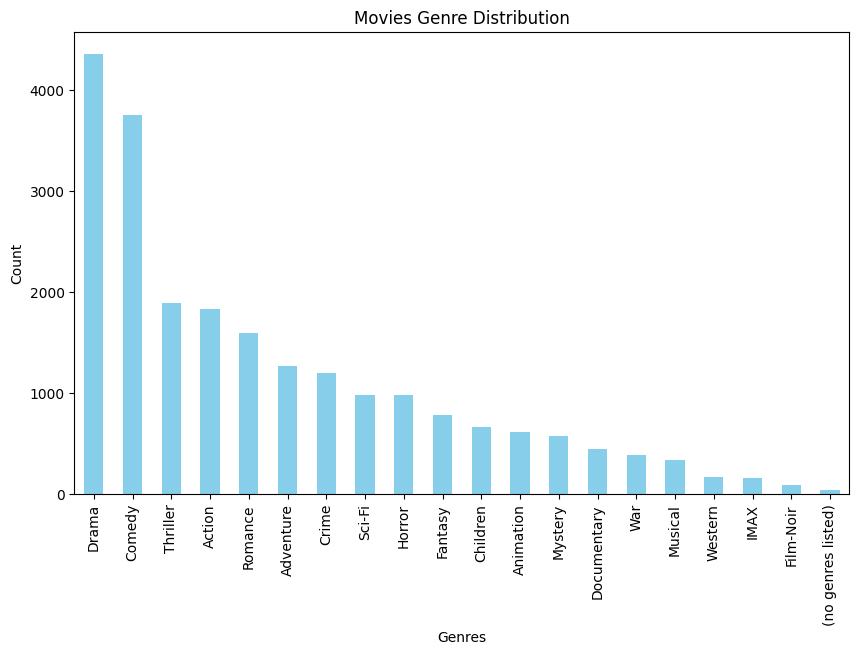

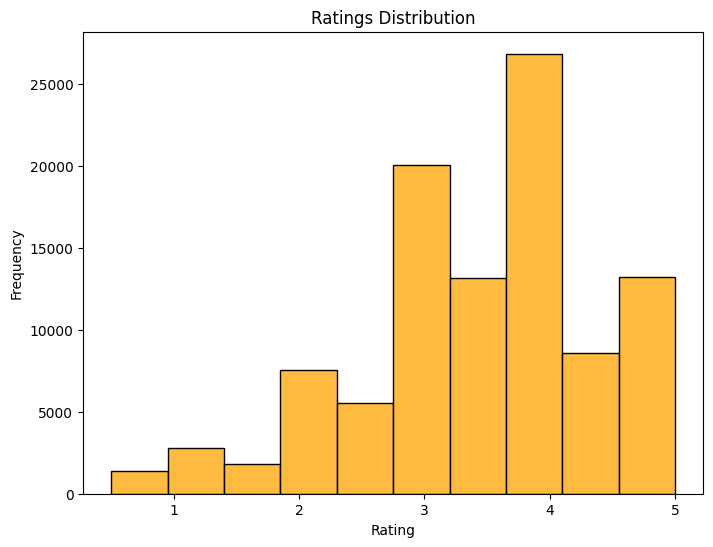

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


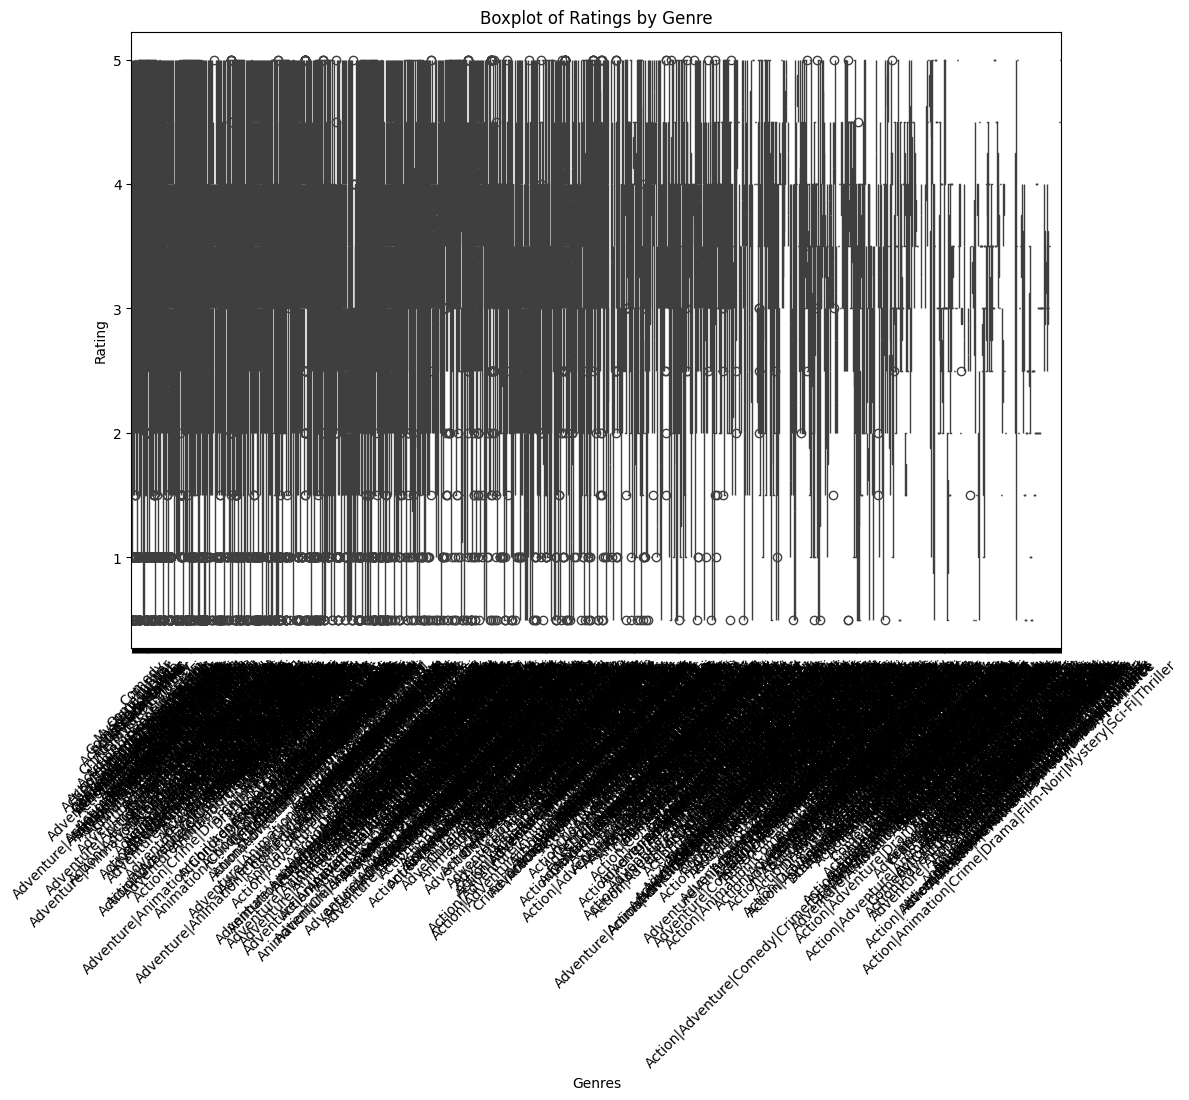


Top 10 Movies by Average Rating:
                                          title  mean_rating  rating_count
7638      Paper Birds (Pájaros de papel) (2010)          5.0             1
8089                 Act of Killing, The (2012)          5.0             1
9065                            Jump In! (2007)          5.0             1
9076                               Human (2015)          5.0             1
9078                        L.A. Slasher (2015)          5.0             1
4245                           Lady Jane (1986)          5.0             1
8136             Bill Hicks: Revelations (1993)          5.0             1
8130               Justice League: Doom (2012)           5.0             1
4240  Open Hearts (Elsker dig for evigt) (2002)          5.0             1
9104                     Formula of Love (1984)          5.0             1


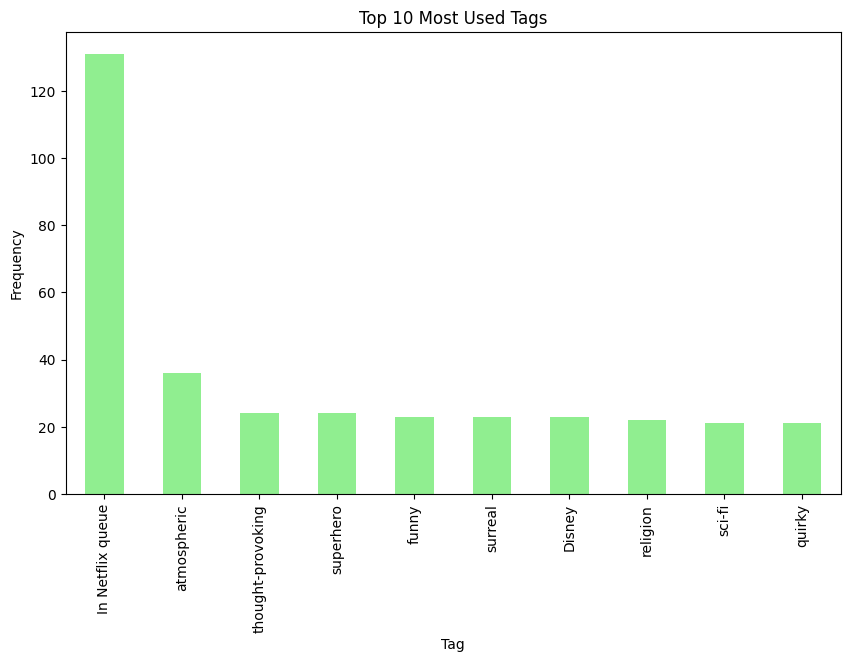

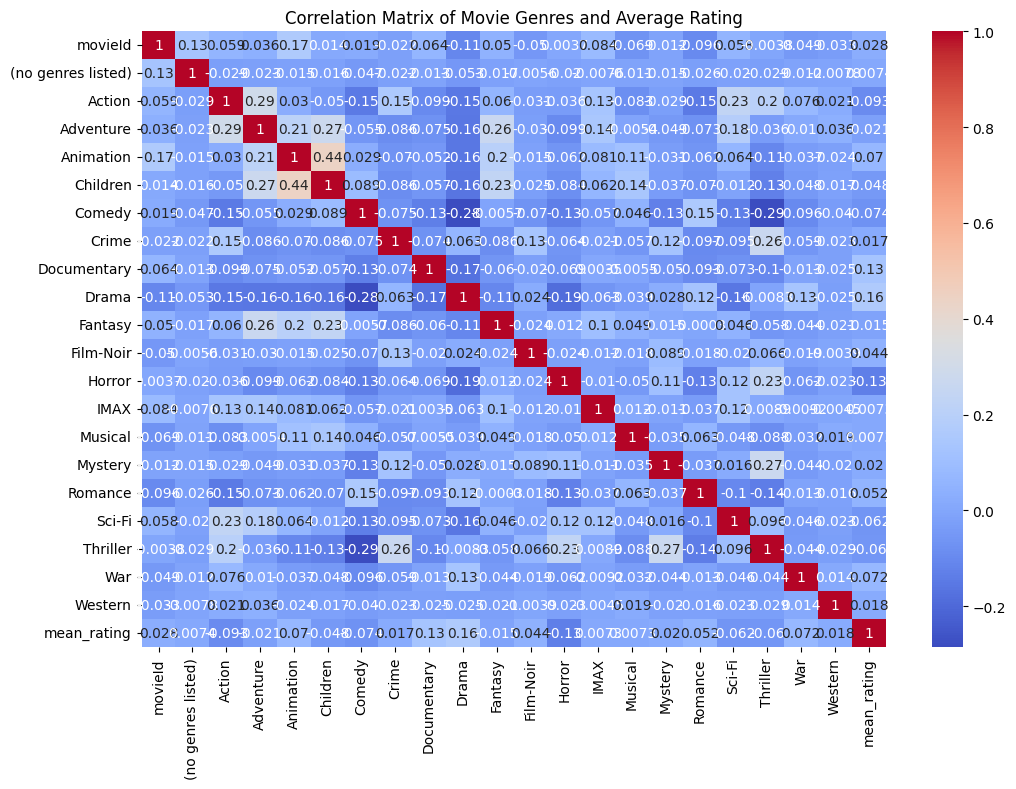


A/B Test Results:
Group A Average Rating: 3.5014181443135386
Group B Average Rating: 3.5016958229203854
RMSE: 0.8815

Predicted rating for User 1 on Movie 10: 4.12736139740167


In [118]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Step 1: Load datasets
movies_df = pd.read_csv('./data/movies.csv')
ratings_df = pd.read_csv('./data/ratings.csv')
tags_df = pd.read_csv('./data/tags.csv')

# Step 2: Data Cleaning
# Remove duplicates
movies_df.drop_duplicates(inplace=True)
ratings_df.drop_duplicates(inplace=True)
tags_df.drop_duplicates(inplace=True)

# Handle missing values (fill with appropriate methods)
movies_df.fillna('', inplace=True)  # Fill missing genres with an empty string
ratings_df['rating'].fillna(ratings_df['rating'].mean(), inplace=True)  # Fill missing ratings with mean
tags_df.fillna('', inplace=True)  # Fill missing tags with an empty string

# Convert 'timestamp' in ratings and tags to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')

# Display basic info
print("Movies DataFrame:")
print(movies_df.head())
print("\nRatings DataFrame:")
print(ratings_df.head())
print("\nTags DataFrame:")
print(tags_df.head())

# Step 3: Data Exploration

# Movie genres distribution
genres_df = movies_df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
movies_genres_count = genres_df.value_counts()

# Plot genre distribution
plt.figure(figsize=(10,6))
movies_genres_count.plot(kind='bar', color='skyblue')
plt.title('Movies Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

# Step 4: Ratings distribution
plt.figure(figsize=(8,6))
sns.histplot(ratings_df['rating'], bins=10, kde=False, color='orange')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Boxplot of ratings by genre
plt.figure(figsize=(12, 8))
sns.boxplot(data=ratings_df.join(movies_df.set_index('movieId'), on='movieId'), x='genres', y='rating')
plt.xticks(rotation=45)
plt.title('Boxplot of Ratings by Genre')
plt.ylabel('Rating')
plt.xlabel('Genres')
plt.show()

# Average rating per movie
movie_ratings = ratings_df.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()
movie_ratings.columns = ['movieId', 'mean_rating', 'rating_count']
top_rated_movies = movie_ratings.merge(movies_df, on='movieId').sort_values(by='mean_rating', ascending=False).head(10)

print("\nTop 10 Movies by Average Rating:")
print(top_rated_movies[['title', 'mean_rating', 'rating_count']])

# Step 5: Tag analysis
# Popular tags
top_tags = tags_df['tag'].value_counts().head(10)

# Plot popular tags
plt.figure(figsize=(10,6))
top_tags.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Most Used Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.show()

# Step 6: Feature Engineering
# Feature 1: Average rating per user
user_avg_rating = ratings_df.groupby('userId').agg({'rating': 'mean'}).reset_index()
user_avg_rating.columns = ['userId', 'avg_user_rating']

# Feature 2: Total ratings per movie
movie_total_ratings = ratings_df.groupby('movieId').size().reset_index(name='total_ratings')

# Merge with the movies data
movies_features_df = movies_df.merge(movie_total_ratings, on='movieId')

# Step 7: Correlation heatmap
# Convert genres into multiple columns with binary encoding for each genre
genres_encoded = movies_df['genres'].str.get_dummies(sep='|')
movies_with_genres = pd.concat([movies_df[['movieId', 'title']], genres_encoded], axis=1)

# Merge with average ratings
movies_with_genres = movies_with_genres.merge(movie_ratings[['movieId', 'mean_rating']], on='movieId')

# Correlation matrix - select only numeric columns
plt.figure(figsize=(12,8))
correlation_matrix = movies_with_genres.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Movie Genres and Average Rating')
plt.show()

# Step 8: A/B Testing (Example)
# Splitting the dataset into two groups (A and B)
group_A = ratings_df.sample(frac=0.5, random_state=42)
group_B = ratings_df.drop(group_A.index)

# Compute the average rating for both groups
avg_rating_A = group_A['rating'].mean()
avg_rating_B = group_B['rating'].mean()

print(f"\nA/B Test Results:")
print(f"Group A Average Rating: {avg_rating_A}")
print(f"Group B Average Rating: {avg_rating_B}")

# Step 9: Recommendation System
# Prepare data for surprise library
reader = Reader(rating_scale=(0.5, 5.0))  # Define the scale of ratings
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Use SVD for collaborative filtering
model = SVD()
model.fit(trainset)

# Make predictions
predictions = model.test(testset)

# Evaluate the model
accuracy.rmse(predictions)

# Predict ratings for a specific user and movie
user_id = 1  # example user
movie_id = 10  # example movie
predicted_rating = model.predict(user_id, movie_id)
print(f"\nPredicted rating for User {user_id} on Movie {movie_id}: {predicted_rating.est}")

# Step 10: Saving Results
# Save the processed datasets
movies_with_genres.to_csv('movies_with_genres.csv', index=False)
user_avg_rating.to_csv('user_avg_rating.csv', index=False)
